In [1]:
%load_ext autoreload
%autoreload 2
import ipyvolume as ipv
import numpy as np
import numpy.ma as ma
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import ImageGrid,make_axes_locatable,host_subplot
from datetime import datetime, timedelta
import pytz as pytz
import sys
import os
import pyPIPS.thermolib as thermo
import pyPIPS.DSDlib as dsd
import pyPIPS.disdrometer_module as dis
import pyPIPS.plotmodule as pm
import pyPIPS.simulator as sim
import pyPIPS.parsivel_params as pp
import pyPIPS.PIPS as pips
import pandas as pd
import xarray as xr
import glob
import numpy.random as random
from scipy.stats import gamma, uniform
from scipy.special import gamma as gammafunc
from metpy.plots import ctables
# Weird that you have to do this twice...
# %matplotlib notebook
# %matplotlib notebook 


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/pyart/graph/cm.py:104: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/pyart/graph/cm_colorblind.py:32: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:


In [2]:
# Some global parameters
rhoacst = 1.0 # kg m^-3
cr = 1000.*np.pi/6.

sampling_area_mm2 = pp.parsivel_parameters['sensor_area_mm2']
sampling_width_mm = pp.parsivel_parameters['sensor_width_mm']
sampling_length_mm = pp.parsivel_parameters['sensor_length_mm']

sampling_width = sampling_width_mm / 1000.
sampling_length = sampling_length_mm / 1000.

In [133]:
# Function definitions
def plotDSD(Dl, Dmid, Dr, ND, ax=None):
    """Plots a DSD on a semilog plot"""
    if ax is None:
        fig = plt.figure(figsize=(8,6))
        ax = fig.add_subplot(111)
    ax.bar(Dl, ND, Dr-Dl, 10.**2., align='edge', log=True, color='tan', edgecolor = 'k', label='exact')
    ax.set_yscale('log')
    ax.set_ylim(10.**2., 10.**6.)
    ax.set_xlim(0., 9.)
    ax.set_xlabel('D (mm)')
    ax.set_ylabel(r'N(D) $(m^{-4})$')
    
    return ax

def plotVD(Dl, Dmid, Vl, countsMatrix, Vt_fit, ax=None, strongwindflag=False):
    """Plot drop counts in each velocity/diameter bin for a given DSD"""
    if ax is None:
        fig = plt.figure(figsize=(8,6))
        ax = fig.add_subplot(111)
    countsplot = ma.masked_where(countsMatrix <= 0, countsMatrix)

    C = ax.pcolor(Dl, Vl, countsplot, vmin=1, vmax=50, edgecolors='w')
    ax.plot(Dmid, Vt_fit, c='r')
    # ax1.scatter(X[0:10,20:31],Y[0:10,20:31],c='r',marker='x')
    fig.colorbar(C)

    if(strongwindflag):
        ax.text(0.5, 0.5, 'Flagged for strong wind contamination!',
                 horizontalalignment='center',
                 verticalalignment='center', color='y',
                 transform=ax.transAxes)
#     if(plot_strongwindQC):
#         ax1.scatter(X[strongwindmask], Y[strongwindmask], c='r', marker='x', alpha=1.0)
#     if(plot_splashingQC):
#         ax1.scatter(X[splashmask], Y[splashmask], c='w', marker='o', alpha=0.75)
#         # ax1.pcolor(min_diameter,min_fall_bins,ma.masked_array(splashmask,mask=-splashmask),cmap=cm.Reds,alpha=0.1)
#     if(plot_marginQC):
#         ax1.scatter(X[marginmask], Y[marginmask], c='g', marker='x', alpha=0.1)
#         # ax1.pcolor(min_diameter,min_fall_bins,ma.masked_array(marginmask,mask=-marginmask),cmap=cm.Reds,alpha=0.1)
#     if(plot_rainfallspeedQC):
#         ax1.scatter(X[fallspeedmask], Y[fallspeedmask], c='k', marker='x', alpha=0.5)
#         # ax1.pcolor(min_diameter,min_fall_bins,ma.masked_array(fallspeedmask,mask=-fallspeedmask),cmap=cm.gray,alpha=0.1)
#     if(plot_rainonlyQC):
#         ax1.scatter(X[rainonlymask], Y[rainonlymask], c='g', marker='x', alpha=0.5)

    ax.set_xlim(0.0, 9.0)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1.0))
    ax.set_xlabel('D (mm)')
    ax.set_ylim(0.0, 15.0)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1.0))
    ax.set_ylabel(r'V$_T$ (m s$^{-1}$)')

In [134]:
D = pp.parsivel_parameters['avg_diameter_bins_mm'] / 1000.
Dl = pp.parsivel_parameters['min_diameter_bins_mm'] / 1000.
Dr = pp.parsivel_parameters['max_diameter_bins_mm'] / 1000.

Dedges = np.append(Dl, Dr[-1])
print(Dedges)

alphar = 2.0
qr = 1.0 # g kg^-1
N0r = 8.0e11 # M-P value (m^-4)

ND, Ntr, lamdar, alphar = dsd.calc_gamma_DSD(rhoacst, D, cr, qr, N0=N0r, alpha=alphar)
print(Ntr)

# ND_sample = sim.samplegammaDSD(Ntr, lamdar, alphar, bins=Dedges)

# print(ND)
# print(ND_sample)

[0.       0.000125 0.00025  0.000375 0.0005   0.000625 0.00075  0.000875
 0.001    0.001125 0.00125  0.0015   0.00175  0.002    0.00225  0.0025
 0.003    0.0035   0.004    0.0045   0.005    0.006    0.007    0.008
 0.009    0.01     0.012    0.014    0.016    0.018    0.02     0.023
 0.026   ]
225.6758334191025


Dmax_index =  31
sampling height =  103.9388043622587
sampling volume =  0.5612695435561968
number concentration =  225.6758334191025
number of particles in sampling volume =  126
minimum, maximum diameter in sample =  8.505864171192363e-05 0.006478935377553553
maximum allowed diameter =  0.026
number of particles less than Dmax =  126
number of particles above the lowest two bins =  122
number of particles within allowable diameter range =  122
minimum, maximum particle diameter in truncated sample =  0.00030289799276349825 0.006478935377553553
number of particles that fall through sampling area =  66
number of these that are margin fallers =  3
Removing margin fallers!
(33,)


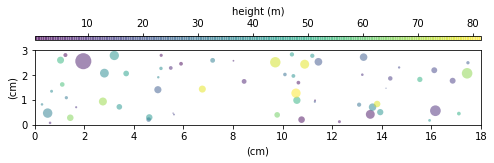

In [169]:
intv=10
remove_margins = True
Vtr = pips.calc_empirical_fallspeed(D*1000., correct_rho=True, rho=rhoacst)
sample_dict = sim.create_random_gamma_DSD(Ntr, lamdar, alphar, Vtr, 
                                          sampling_length, sampling_width, Dl, D, Dr, sampling_interval=intv,
                                          verbose=True, remove_margins=remove_margins, rhocorrect=True, 
                                          rho=rhoacst)
positions = sample_dict['positions']
diameters = sample_dict['diameters']
velocities = sample_dict['velocities']
ND_sample = sample_dict['ND']
margin_mask = sample_dict['margin_mask']

positions = positions.T
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
c = pm.circles(positions[0]*100, positions[1]*100, diameters/2.*100, c=positions[2], alpha=0.5)
divider = make_axes_locatable(ax)
cax = divider.append_axes("top", size="5%", pad=0.15)
cbar = plt.colorbar(c, cax=cax, orientation='horizontal')
cbar.ax.set_xlabel('height (m)')
cbar.ax.xaxis.set_label_position('top')
cbar.ax.xaxis.set_ticks_position('top')
if not remove_margins:
    pm.circles(positions[0][margin_mask], positions[1][margin_mask], diameters[margin_mask], c='r', alpha=1.0)
#ax.scatter(positions[0], positions[1], c=positions[2], alpha=0.5, s=diameters*1000.)
ax.set_xlabel('(cm)')
ax.set_ylabel('(cm)')
ax.set_xlim(0.0, sampling_length*100)
ax.set_ylim(0.0, sampling_width*100)
ax.set_aspect('equal')
plt.savefig('parsivel_beam_drops_{:d}_intv.png'.format(intv), dpi=300, bbox_inches='tight')

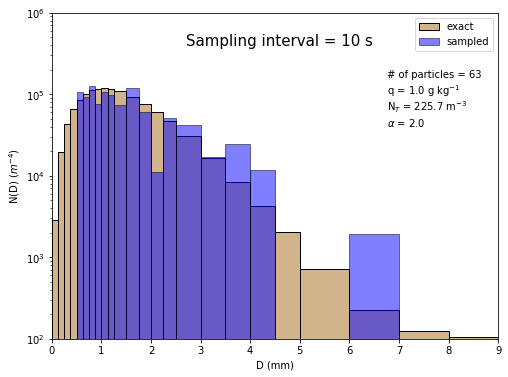

In [170]:
# Plot ND along with sampled ND
ax = plotDSD(Dl*1000., D*1000., Dr*1000., ND)
ax.bar(Dl*1000., ND_sample, (Dr-Dl)*1000., 10.**2., align='edge', log=True, color='b', edgecolor = 'k', alpha=0.5, label='sampled')
ax.text(0.3, 0.9, 'Sampling interval = {:d} s'.format(intv), transform=ax.transAxes, fontsize=15)
ax.text(0.75, 0.8, '# of particles = {:d}'.format(len(diameters)), transform=ax.transAxes)
ax.text(0.75, 0.75, r'q = {:0.1f}'.format(qr) + r' g kg$^{-1}$', transform=ax.transAxes)
ax.text(0.75, 0.7, r'N$_{T}$'+ ' = {:0.1f}'.format(Ntr) + r' m$^{-3}$', transform=ax.transAxes)
ax.text(0.75, 0.65, r'$\alpha$ = {:0.1f}'.format(alphar), transform=ax.transAxes)
ax.legend()
plt.savefig('gamma_DSD_demo_{:d}_intv.png'.format(intv), dpi=300, bbox_inches='tight')

In [62]:
scale=5
zscale=0.02
ipv.figure()
#ipv.scatter(positions[0], positions[1], positions[2], marker='sphere', color='blue')
ipv.quickscatter(positions[0]*scale, positions[1]*scale, positions[2]*zscale, 
                 size=diameters*scale*200., marker="sphere", color='blue')
print(positions[0], positions[1], positions[2]/100.)



ipv.zlim(0., 1.0)
ipv.xlim(0., sampling_length*scale)
ipv.ylim(0., sampling_width*scale)
ipv.squarelim()
#ipv.xyzlim(-2, 2)
ipv.show()

[0.12788997 0.07696056 0.13597595 ... 0.11151285 0.12778736 0.10705402] [0.01417649 0.01671344 0.01480965 ... 0.02970537 0.00698098 0.02072963] [0.17941634 1.62858378 0.15381068 ... 0.70658901 1.22131533 0.1295116 ]


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/ipywidgets/widgets/widget.py:411: DeprecationWarning: Passing unrecoginized arguments to super(PerspectiveCamera).__init__(width=400, height=500).
object.__init__() takes exactly one argument (the instance to initialize)
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/ipywidgets/widgets/widget.py:411: DeprecationWarning: Passing unrecoginized arguments to super(PerspectiveCamera).__init__(width=400, height=500).
object.__init__() takes exactly one argument (the instance to initialize)
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/ipywidgets/widgets/widget.py:411: DeprecationWarning: Passing unrecoginized argumen